In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

# -------------------------- CONFIG -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
DATASET_DIR = "F:/Lettuce_leaf_classification/Lettuce_disease_datasets"
EXTRACTED_FEATURE_CSV = "F:\Lettuce_leaf_classification\Lettuce_leaf_classification\data\leaf_aug_features.xlsx"
IMG_SIZE = 224
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"  # Your MLflow server URI

# ---------------------- TRANSFORMS -----------------------------
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# ---------------------- LOAD PRETRAINED CNN --------------------
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # remove final FC
resnet.eval().to(DEVICE)


# ---------------------- FEATURE EXTRACTION ---------------------
def extract_features(dataset_dir, output_csv):
    rows = []
    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for fname in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
            path = os.path.join(class_dir, fname)
            try:
                img = Image.open(path).convert("RGB")
                tensor = transform(img).unsqueeze(0).to(DEVICE)

                with torch.no_grad():
                    features = resnet(tensor).squeeze().cpu().numpy()

                rows.append(
                    {
                        "image_name": fname,
                        "label": label,
                        **{f"feat_{i}": f for i, f in enumerate(features.flatten())},
                    }
                )
            except Exception as e:
                print(f"Error processing {path}: {e}")

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"Saved extracted features to {output_csv}")


# ---------------------- TRAINING FUNCTION ----------------------
def train_model(csv_path):
    df = pd.read_csv(csv_path)
    X = df.drop(columns=["image_name", "class"])
    y = df["class"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)

    return clf, acc, f1, cm, y_test, y_pred


# ------------------ PLOT CONFUSION MATRIX ----------------------
def plot_confusion_matrix(cm, class_names, save_path="confusion_matrix.png"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


# ----------------------- MLFLOW LOGGER -------------------------
def log_with_mlflow(
    model, acc, f1, cm, y_true, y_pred, artifact_path="confusion_matrix.png"
):
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment("Lettuce_Classification")

    with mlflow.start_run():
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)

        plot_confusion_matrix(
            cm, class_names=sorted(set(y_true)), save_path=artifact_path
        )
        mlflow.log_artifact(artifact_path)

        mlflow.sklearn.log_model(model, "random_forest_model")


# --------------------------- MAIN ------------------------------
if __name__ == "__main__":
    if not os.path.exists(EXTRACTED_FEATURE_CSV):
        extract_features(DATASET_DIR, EXTRACTED_FEATURE_CSV)

    model, acc, f1, cm, y_true, y_pred = train_model(EXTRACTED_FEATURE_CSV)
    log_with_mlflow(model, acc, f1, cm, y_true, y_pred)

    print(f"Training complete. Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

cuda


f:\PyTorch_GPU\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\PyTorch_GPU\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2025/08/07 20:10:33 INFO mlflow.tracking.fluent: Experiment with name 'Lettuce_Classification' does not exist. Creating a new experiment.
2025/08/07 20:10:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/07 20:10:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example

🏃 View run redolent-asp-637 at: http://127.0.0.1:5000/#/experiments/570064072894460474/runs/d18ab7feccde495fbb442c36310ab16b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570064072894460474
Training complete. Accuracy: 0.9530, F1-score: 0.9421


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:

!pip install xgboost


     -------------------------------------- 149.9/149.9 MB 4.7 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import torch
import numpy as np
import mlflow
import mlflow.sklearn
from torchvision import datasets, models, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from torchvision import datasets, transforms
import torch

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Correct path (any of the formats below will work)
data_dir = r"F:\Lettuce_leaf_classification\DNN_dataloader\train"

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
class_names = dataset.classes

print("Classes:", class_names)

Classes: ['BACT', 'DML', 'HLTY', 'PML', 'SBL', 'SPW', 'VIRL', 'WLBL']


In [ ]:
def get_cnn_feature_extractor(model_name="vgg16"):
    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier = torch.nn.Identity()  # Remove FC layer
        feature_dim = 25088
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier = torch.nn.Identity()
        feature_dim = 1280
    else:
        raise ValueError("Only vgg16 or mobilenet supported.")
    model.eval()
    return model, feature_dim

In [ ]:
def extract_deep_features(model, dataloader):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            outputs = model(inputs)
            features = outputs.view(outputs.size(0), -1)
            all_features.append(features.numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
def train_ml_model(X, y, model_type="svc"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    if model_type == "svc":
        param_grid = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
        model = GridSearchCV(
            SVC(probability=True), param_grid, cv=3, scoring="accuracy"
        )
    elif model_type == "rf":
        param_grid = {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}
        model = GridSearchCV(
            RandomForestClassifier(), param_grid, cv=3, scoring="accuracy"
        )
    elif model_type == "xgb":
        param_grid = {
            "n_estimators": [100],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5],
        }
        model = GridSearchCV(
            XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
            param_grid,
            cv=3,
            scoring="accuracy",
        )
    else:
        raise ValueError("Unsupported model")

    model.fit(X_train, y_train)
    return model, X_test, y_test

In [ ]:
def evaluate_and_log(model, X_test, y_test, model_name, cnn_backbone):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    conf_mat = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob, multi_class="ovr")

    # MLflow Logging
    with mlflow.start_run(run_name=f"{model_name}_{cnn_backbone}"):
        mlflow.log_param("model", model_name)
        mlflow.log_param("cnn_backbone", cnn_backbone)
        mlflow.log_metric("accuracy", report["accuracy"])
        mlflow.log_metric("roc_auc", auc)
        mlflow.log_params(model.best_params_)

        # Confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig("conf_mat.png")
        mlflow.log_artifact("conf_mat.png")

        # ROC Curve (for binary or OvR)
        if y_prob.shape[1] == 2:
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title("ROC Curve")
            plt.legend()
            plt.savefig("roc_curve.png")
            mlflow.log_artifact("roc_curve.png")

        mlflow.sklearn.log_model(model, "sk_model")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\amans/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:41<00:00, 5.48MB/s] 
100%|██████████| 219/219 [13:15<00:00,  3.63s/it]
2025/08/07 22:56:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/07 22:56:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgb_vgg16 at: http://127.0.0.1:5000/#/experiments/570064072894460474/runs/fcf2a22d972340118a249ae5d537ec35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570064072894460474


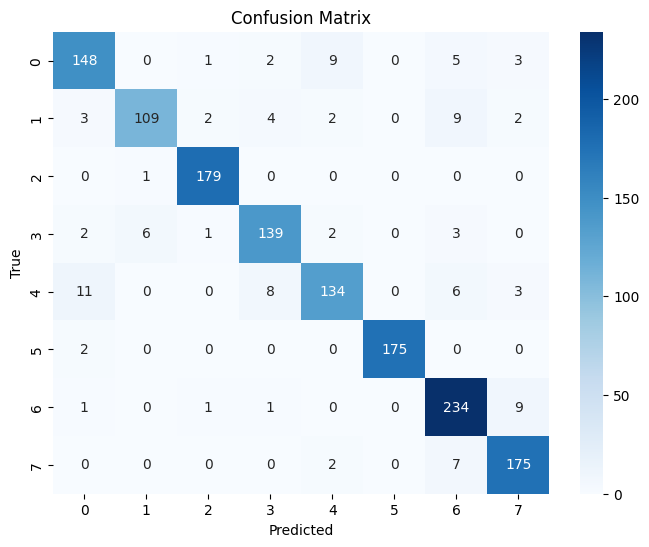

In [ ]:
if __name__ == "__main__":
    cnn_backbone = "vgg16"  # or 'mobilenet'
    model_type = "xgb"  # svc, rf, xgb

    cnn_model, _ = get_cnn_feature_extractor(cnn_backbone)
    features, labels = extract_deep_features(cnn_model, dataloader)
    model, X_test, y_test = train_ml_model(features, labels, model_type)
    evaluate_and_log(model, X_test, y_test, model_type, cnn_backbone)